In [2]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

2022-09-18 17:24:29.313232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 17:24:29.413428: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-18 17:24:29.845538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/envs/ucla_deeplearning/lib
2022-09-18 17:24:29.845577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2022-09-18 17:24:30.563534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 17:24:30.567692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 17:24:30.567847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [4]:
%%capture
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/weather/jobs/transform_batch/20200927-010303_94e076593fe6eeb97c0a5f442b4198dc'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 4

In [5]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 31.9+ MB


In [6]:
score_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57576 entries, ('Albuquerque/2249/0', Timestamp('2017-07-15 13:00:00')) to ('Vancouver/2623/10', Timestamp('2017-07-07 20:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  57576 non-null  float64
 1   humidity     57576 non-null  float64
 2   pressure     57576 non-null  float64
 3   wind_speed   57576 non-null  float64
dtypes: float64(4)
memory usage: 2.1+ MB


In [7]:
train_X.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   

                                        wind_speed  
sample             time                             
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  
                   2015-02-16 10:00:00         3.0  
                   2015-02-16 11:00:00         2.0  
                   2015-02-16 12:00:00         2.0  
                   2015-02-16 13:00:00         1.0

In [8]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [9]:
train_X.loc['Albuquerque/1112/1'].head()

,temperature,humidity,pressure,wind_speed
time,,,,
2015-02-20 18:00:00,282.116500,46.0,1023.0,3.0
2015-02-20 19:00:00,287.061667,40.0,1021.0,4.0
2015-02-20 20:00:00,288.236333,38.0,1019.0,4.0
2015-02-20 21:00:00,286.928000,35.0,1020.0,4.0
2015-02-20 22:00:00,288.930333,34.0,1017.0,5.0


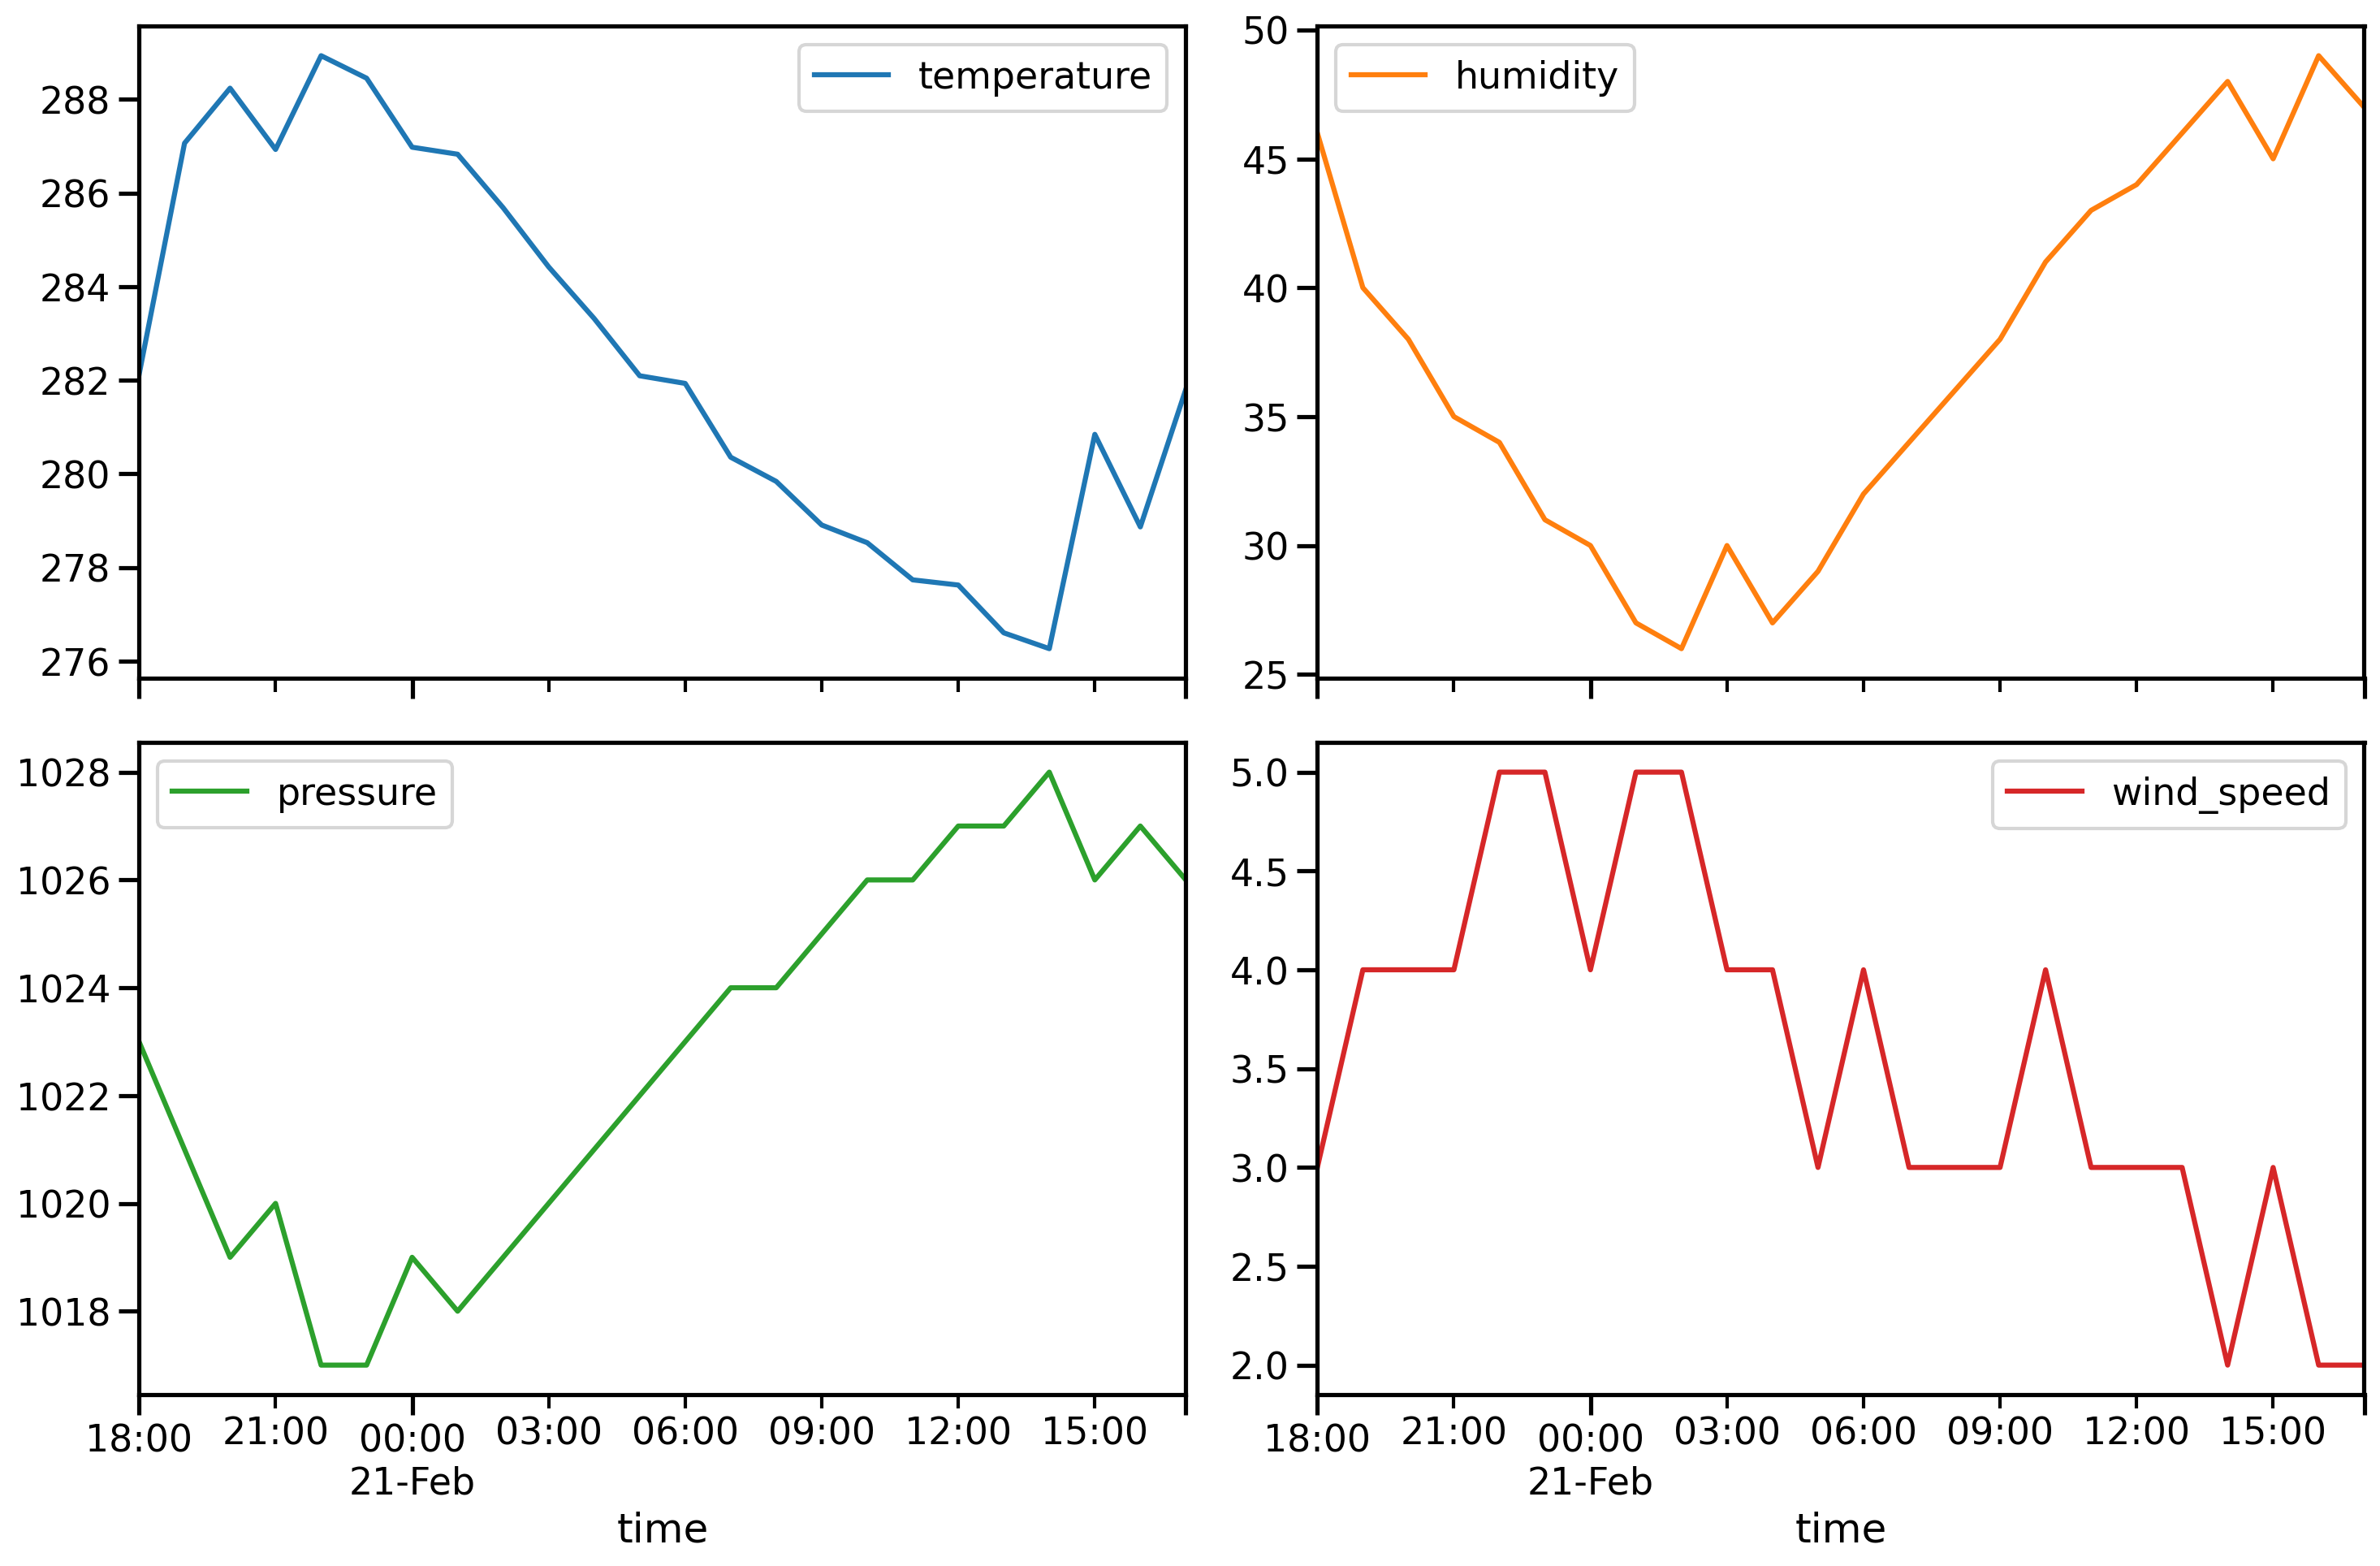

In [10]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

In [12]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)"


In [13]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.

In [14]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y']
)

,actual shape,expected shape
train_X,"(34436, 24, 4)","(34436, 24, 4)"
train_y,"(34436, 24)","(34436, 24)"
validate_X,"(2288, 24, 4)","(2288, 24, 4)"
validate_y,"(2288, 24)","(2288, 24)"


In [17]:
from tensorflow.keras.layers import GRU, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

layers = [
        GRU(
            input_shape=(condition_window, features_length),
            units=32,
            return_sequences=True,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
        ),
        BatchNormalization(),
        GRU(
            units=16,
            return_sequences=False,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=46),
            recurrent_initializer=GlorotUniform(seed=47),
        ),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            kernel_initializer=GlorotUniform(seed=48),
            activation='linear'
        )
]

model = Sequential(layers)

2022-09-18 17:29:15.679372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 17:29:15.680514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 17:29:15.680694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 17:29:15.680826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24, 32)            3648      
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 32)            128       
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                2400      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
Total params: 6,648
Trainable params: 6,552
Non-trainable params: 96
_________________________________________________________________


In [25]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

model.compile(
    optimizer=Adam(lr=0.01),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        r2_score,
        mean_error
    ]
)

In [26]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=1,
    batch_size=100,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

345/345 [==============================] - 45s 130ms/step - loss: 39212.2070 - mean_absolute_error: 176.0164 - r2_score: -288.9903 - mean_error: -175.7335 - val_loss: 526.8882 - val_mean_absolute_error: 22.3174 - val_r2_score: -19.1534 - val_mean_error: -22.3056 - lr: 0.0100
CPU times: user 1min 32s, sys: 10.1 s, total: 1min 42s
Wall time: 48.6 s


In [27]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

rnn_metrics

train                     validate                    
        MSE    MAE    R2     ME      MSE    MAE    R2     ME
rnn  625.74  24.43 -3.56 -24.43   526.89  22.32 -4.98 -22.32

In [28]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

In [29]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(2)

train       validate      
               MSE    R2      MSE    R2
mean         26.77  0.80    37.23  0.58
constant     21.82  0.84    40.25  0.54
regression   30.53  0.78    29.94  0.66
rnn         625.74 -3.56   526.89 -4.98

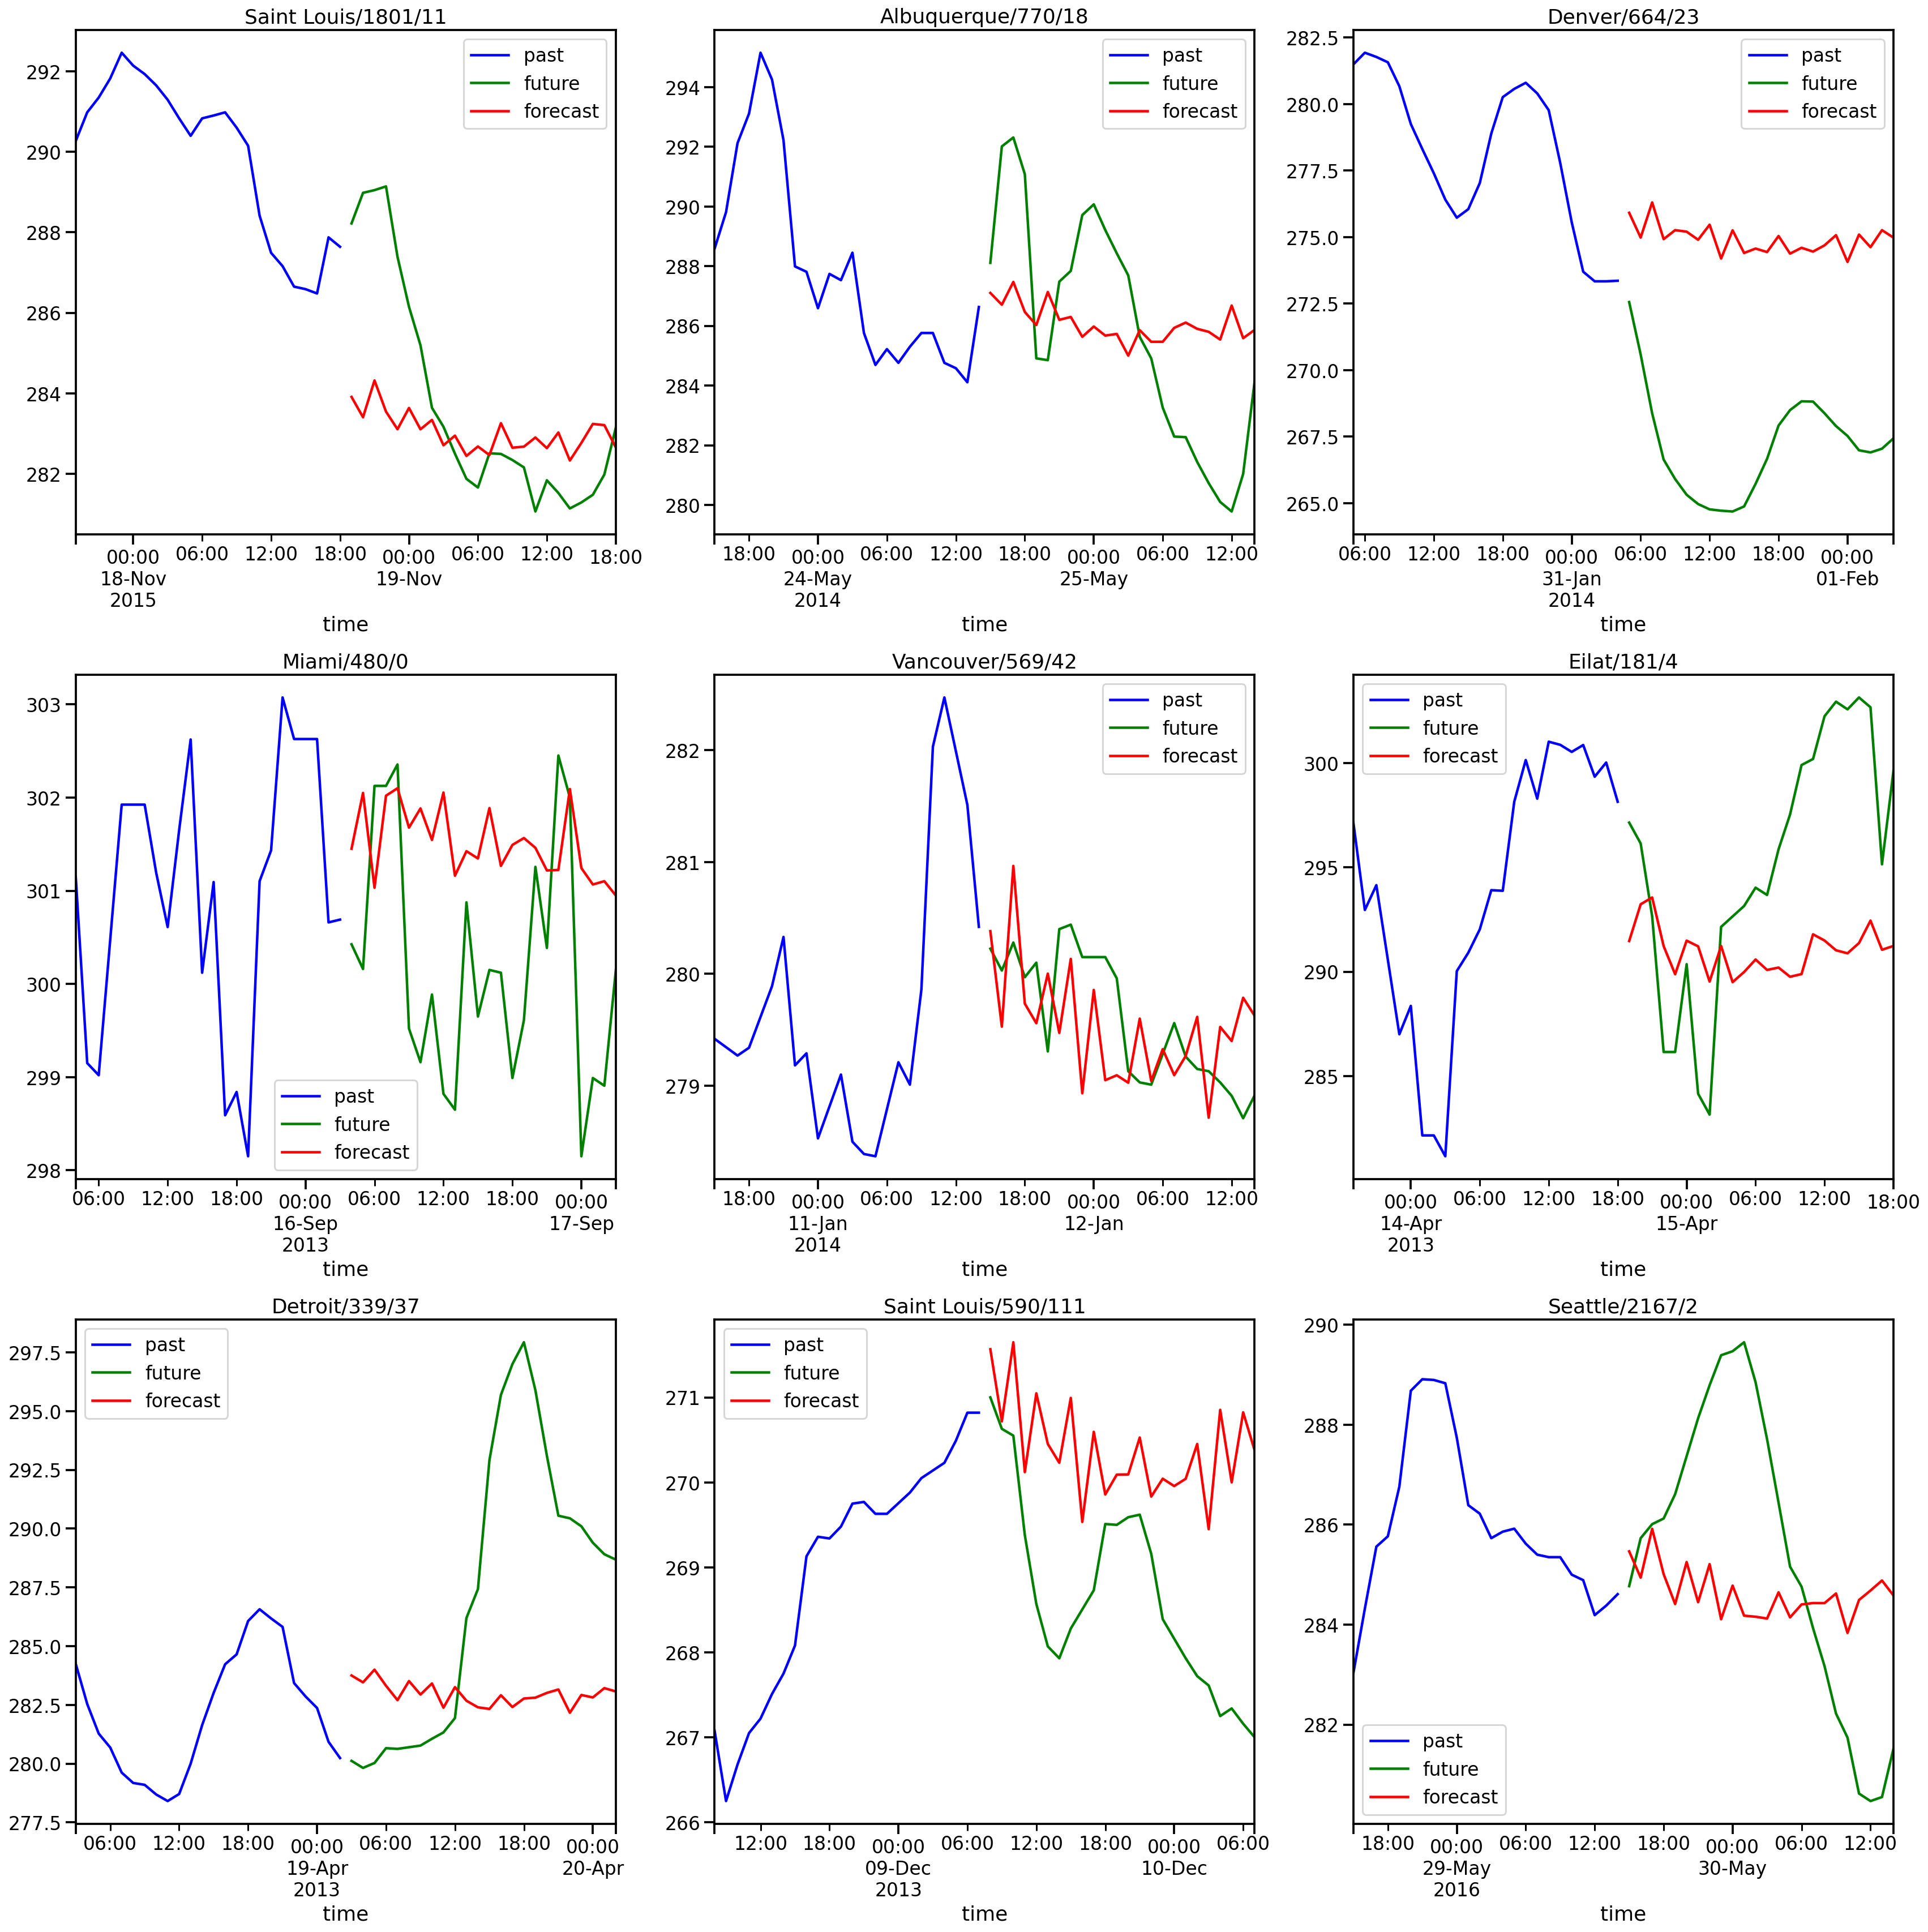

In [22]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat.rename(columns={'temperature': 'forecast'})
)

In [18]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.
score_y_hat = pd.DataFrame()

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the columns names.
# There was a similar example of this in the notebook from the first assignment.

# Expected output: (Index(['temperature'], dtype='object'), (57576, 1))
score_y_hat.columns, score_y_hat.shape

(Index([], dtype='object'), (0, 0))

In [19]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')